## The Role of AI in Capital Asset Management at DCAMM

Anuraag Macha, Matthew Branum

College of Professional Studies, Northeastern University

ALY 6980: Capstone

Dr. Matthew Goodwin

June 28, 2025

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import shap

/opt/miniconda3/envs/ml-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the main detailed dataset from the correct sheet
detailed = pd.read_excel(
    'DCAMM NU Project Spending Detail Spring 2025 Term 2025Apr16.xlsx',
    sheet_name='Combined Flat File PM_PMT'
)

# Load the data dictionary from the second tab (optional but useful for reference)
data_dictionary = pd.read_excel(
    'DCAMM NU Project Spending Detail Spring 2025 Term 2025Apr16.xlsx',
    sheet_name='Combined PM_PMT Tbl Dictionary'
)

# Import city/county lookup for geographic enrichment
location_lookup = pd.read_excel('PID_City_County.xlsx')

# Merge city/county data into the main dataset based on PID
detailed = detailed.merge(location_lookup, on='PID', how='left')

# Rename merged city and county columns for clarity
detailed.rename(columns={'City_y': 'City', 'County_y': 'County'}, inplace=True)

In [3]:
# Load RSMeans index
rsmeans = pd.read_excel('Historical RSM Cost Index from DCAMM 2025Apr16.xlsx')

# Clean/reshape RSMeans data if needed (we’ll adjust once we see its structure)

# Parse year and month from acceptance_date
detailed['acceptance_date'] = pd.to_datetime(detailed['acceptance_date'])
detailed['payment_year'] = detailed['acceptance_date'].dt.year
detailed['payment_month'] = detailed['acceptance_date'].dt.month

# Apply DCAMM rules for index year selection
def get_effective_index_year(row):
    if row['payment_month'] <= 6:
        return row['payment_year'] - 1
    else:
        return row['payment_year'] + 1

detailed['effective_index_year'] = detailed.apply(get_effective_index_year, axis=1)

# Preview before merge
detailed[['City', 'acceptance_date', 'payment_year', 'payment_month', 'effective_index_year']].head()

,City,acceptance_date,payment_year,payment_month,effective_index_year
0,PITTSFIELD,2007-11-07,2007,11,2008
1,PITTSFIELD,2007-12-12,2007,12,2008
2,PITTSFIELD,2008-02-13,2008,2,2007
3,PITTSFIELD,2008-03-20,2008,3,2007
4,PITTSFIELD,2008-03-20,2008,3,2007


In [4]:
# Load both RSMeans tabs
rsmeans_index = pd.read_excel(
    'Historical RSM Cost Index from DCAMM 2025Apr16.xlsx',
    sheet_name='Rs Mean Cost Index Table'
)

rsmeans_weights = pd.read_excel(
    'Historical RSM Cost Index from DCAMM 2025Apr16.xlsx',
    sheet_name='% for Weighting RSM Index',
    header=6  # This is the correct row with 'RS Means Indx City' etc.
)

# Clean and convert
rsmeans_weights.rename(columns={
    'RS Means Indx City': 'City',
    '% Total': 'weight'
}, inplace=True)

rsmeans_weights['weight'].head()

0    0.491184
1    0.207192
2    0.100044
3    0.077838
4    0.032296
Name: weight, dtype: float64

In [5]:
# Load both RSMeans tabs
rsmeans_index = pd.read_excel(
    'Historical RSM Cost Index from DCAMM 2025Apr16.xlsx',
    sheet_name='Rs Mean Cost Index Table'
)

rsmeans_weights = pd.read_excel(
    'Historical RSM Cost Index from DCAMM 2025Apr16.xlsx',
    sheet_name='% for Weighting RSM Index',
    header=6  # This is the correct row with 'RS Means Indx City' etc.
)

# Clean and convert
rsmeans_weights.rename(columns={
    'RS Means Indx City': 'City',
    '% Total': 'weight'
}, inplace=True)

rsmeans_weights['weight'] = rsmeans_weights['weight'].astype(float)

# Clean up column names
rsmeans_index.rename(columns={'Places': 'City'}, inplace=True)

# Melt the wide table into long format
rsmeans_long = rsmeans_index.melt(id_vars='City', var_name='Year', value_name='Index')

rsmeans_long = rsmeans_long[pd.to_numeric(rsmeans_long['Year'], errors='coerce').notnull()]
rsmeans_long['Year'] = rsmeans_long['Year'].astype(int)
rsmeans_long = rsmeans_long[(rsmeans_long['Year'] >= 2000) & (rsmeans_long['Year'] <= 2025)]

# Merge weights
rsmeans_long = rsmeans_long.merge(rsmeans_weights[['City', 'weight']], on='City', how='left')

# Calculate weighted index
rsmeans_long['weighted_index'] = rsmeans_long['Index'] * rsmeans_long['weight']

# Compute statewide weighted average index per year
weighted_avg_index = rsmeans_long.groupby('Year')['weighted_index'].sum().reset_index()
weighted_avg_index.rename(columns={'weighted_index': 'statewide_index'}, inplace=True)

In [6]:
print(weighted_avg_index['Year'].unique())

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025]


In [7]:
# Merge into detailed dataset
detailed = detailed.merge(
    weighted_avg_index,
    left_on='effective_index_year',
    right_on='Year',
    how='left'
)

# Set 2025 reference index
index_2025 = weighted_avg_index[weighted_avg_index['Year'] == 2025]['statewide_index'].values[0]

# Calculate inflation-adjusted spend
detailed['adjusted_expended'] = detailed['Expended'] * (index_2025 / detailed['statewide_index'])

# Preview adjustment results
detailed[['Expended', 'statewide_index', 'adjusted_expended']].head()

# Basic stats
print("Raw vs Adjusted Spending:")
print(detailed[['Expended', 'adjusted_expended']].describe())

Raw vs Adjusted Spending:
           Expended
count  4.042900e+04
mean   8.953711e+04
std    3.930719e+05
min   -4.337683e+06
25%    1.076400e+03
50%    2.961600e+03
75%    1.628002e+04
max    1.050000e+07


## Feature Engineering

### Project Timeline

In this section, we engineered time-based features at the project (`PID`) level to better understand the temporal dynamics of capital spending. These features will support downstream modeling (e.g., duration-based cost behavior) and exploratory analysis.

**Features Created:**
- `project_start_date`: First known `service_from_date` for each project
- `project_end_date`: Latest `service_to_date` for each project
- `project_duration_months`: Total project duration (in calendar months)
- `season_of_acceptance`: Season of the year when `acceptance_date` occurred, binned into: Winter, Spring, Summer, Fall

These engineered features will allow us to assess patterns like:
- How long projects actually run
- Whether certain seasons correlate with higher/lower spending
- If duration impacts cumulative cost behavior

In [8]:
# Convert all relevant dates
date_cols = ['service_from_date', 'service_to_date', 'acceptance_date', 'vendor_invoice_date']
for col in date_cols:
    detailed[col] = pd.to_datetime(detailed[col], errors='coerce')

# Project start and end
project_dates = detailed.groupby('PID').agg(
    project_start_date=('service_from_date', 'min'),
    project_end_date=('service_to_date', 'max')
).reset_index()

# Merge back into detailed
detailed = detailed.merge(project_dates, on='PID', how='left')

# Duration in months
detailed['project_duration_months'] = (
    (detailed['project_end_date'] - detailed['project_start_date']) / np.timedelta64(1, 'M')
).round(1)

# Season of acceptance
detailed['season_of_acceptance'] = detailed['acceptance_date'].dt.month % 12 // 3 + 1
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
detailed['season_of_acceptance'] = detailed['season_of_acceptance'].map(season_map)


In [9]:
# Preview a sample of timeline features
detailed[['PID', 'project_start_date', 'project_end_date', 'project_duration_months', 'season_of_acceptance']].drop_duplicates().sample(10, random_state=1)

,PID,project_start_date,project_end_date,project_duration_months,season_of_acceptance
24713,S992,2004-08-02,2006-08-28,24.4,Fall
2761,BSB1501,2014-08-14,2015-10-20,13.9,Fall
18114,ITD0901,2005-11-07,2013-06-30,90.1,Fall
4083,BSD1801,2018-09-01,2019-11-26,14.5,Spring
24678,RCC1802,2019-05-01,2020-11-25,18.5,Summer
32113,TRC1203,2012-03-21,2021-02-16,105.0,Winter
1159,BSB1206,2012-10-25,2018-06-30,66.9,Summer
14617,FRC1001,2010-05-15,2015-06-30,60.4,Spring
5,BCC0701,2007-08-16,2012-11-28,62.3,Summer
26567,SDM1403,2014-07-01,2017-08-14,36.8,Summer


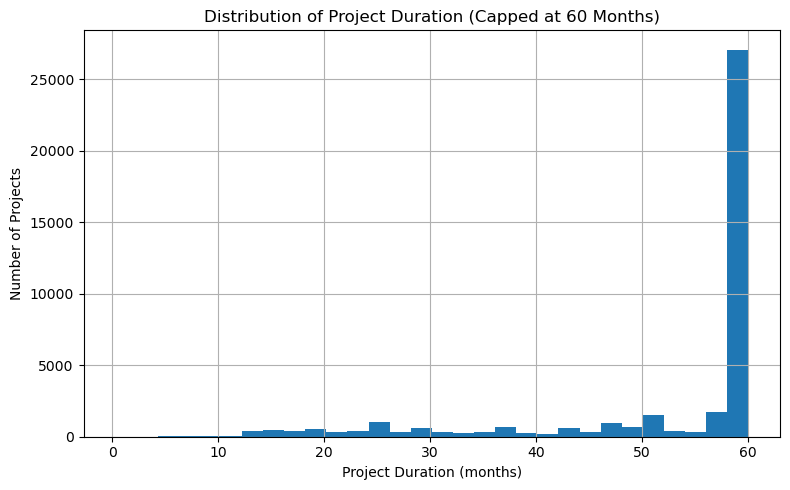

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
detailed['project_duration_months'].dropna().clip(0, 60).hist(bins=30)
plt.title("Distribution of Project Duration (Capped at 60 Months)")
plt.xlabel("Project Duration (months)")
plt.ylabel("Number of Projects")
plt.grid(True)
plt.tight_layout()
plt.show()

### Cumulative Spending Milestones

This section derives time-normalized project spend behavior by computing how project funds are distributed over time. By tracking cumulative spend at the monthly level per project, we extract key lifecycle milestones that are useful for both predictive modeling and diagnostic insight.

**Features Created:**
- `month_reached_50pct_spend`: Month (relative to project start) when 50% of adjusted spending was reached
- `month_reached_95pct_spend`: Month when 95% of adjusted spending was reached
- `is_front_loaded_spend`: Boolean flag indicating whether 50% of spend occurred within the first 25% of project duration

These features help answer:
- Which projects are back-loaded or front-loaded in spend behavior?
- Does early-stage overspending correlate with total cost growth?
- Can lifecycle position explain vendor payment velocity?


In [11]:
# Step 1: Create a month number relative to project start
detailed['project_month'] = (
    (detailed['acceptance_date'] - detailed['project_start_date']) / np.timedelta64(1, 'M')
).round().astype('Int64')

# Step 2: Filter valid rows
spend_df = detailed[['PID', 'project_month', 'adjusted_expended']].dropna()
spend_df = spend_df[spend_df['project_month'] >= 0]

# Step 3: Calculate cumulative spend by project month
spend_df['adjusted_expended'] = pd.to_numeric(spend_df['adjusted_expended'], errors='coerce')
spend_df = spend_df.sort_values(['PID', 'project_month'])
spend_df['cumulative_spend'] = spend_df.groupby('PID')['adjusted_expended'].cumsum()
spend_df['total_spend'] = spend_df.groupby('PID')['adjusted_expended'].transform('sum')
spend_df['cumulative_pct'] = spend_df['cumulative_spend'] / spend_df['total_spend']

# Step 4: Extract milestone months
def get_milestone_month(df, threshold):
    hit = df[df['cumulative_pct'] >= threshold]
    return hit['project_month'].iloc[0] if not hit.empty else pd.NA

milestones = spend_df.groupby('PID').apply(
    lambda df: pd.Series({
        'month_reached_50pct_spend': get_milestone_month(df, 0.50),
        'month_reached_95pct_spend': get_milestone_month(df, 0.95)
    })
).reset_index()

# Step 5: Merge into main dataset
detailed = detailed.merge(milestones, on='PID', how='left')

# Step 6: Create front-loaded flag
detailed['is_front_loaded_spend'] = (
    detailed['month_reached_50pct_spend'] <= (0.25 * detailed['project_duration_months'])
)


In [12]:
# Show a few interesting projects
detailed[['PID', 'project_duration_months', 'month_reached_50pct_spend',
          'month_reached_95pct_spend', 'is_front_loaded_spend']].drop_duplicates().sample(10, random_state=42)

,PID,project_duration_months,month_reached_50pct_spend,month_reached_95pct_spend,is_front_loaded_spend
19880,MCA1401,51.1,33,53,False
21966,NAC1001,97.7,37,61,False
12584,DYS0801,82.5,39,74,False
26912,SDW0901,99.1,64,100,False
2876,BSB1503,51.4,40,50,False
17313,HCC1201,31.7,22,31,False
25473,SDH1001,51.2,40,50,False
37012,UMB0802,89.0,60,85,False
10221,DOC0702,68.8,40,72,False
21295,MMA1201,23.2,18,25,False


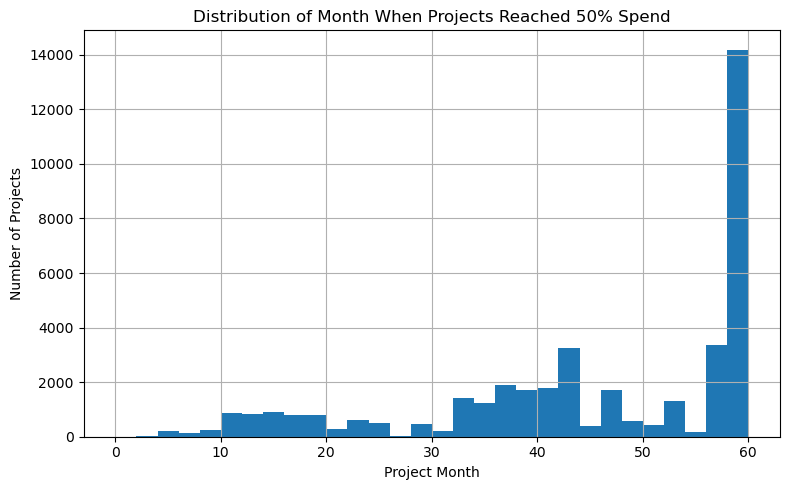

In [13]:
plt.figure(figsize=(8,5))
detailed['month_reached_50pct_spend'].dropna().clip(0, 60).hist(bins=30)
plt.title("Distribution of Month When Projects Reached 50% Spend")
plt.xlabel("Project Month")
plt.ylabel("Number of Projects")
plt.grid(True)
plt.tight_layout()
plt.show()

### Vendor Payment Lag

This feature block captures operational efficiency by measuring the number of days between various payment-related events. These metrics help assess whether longer approval times are correlated with overspending or project complexity.

**Features Created:**
- `invoice_to_acceptance_days`: Time (in days) between vendor invoice date and acceptance
- `service_to_acceptance_days`: Lag between end of service and final approval
- `payment_lag_days`: Full window from service start to acceptance
- `invoice_issued_before_acceptance`: Boolean flag showing invoice precedes approval
- `approval_delay_bucket`: Categorical feature to bin short/medium/long delays

These lag features are valuable for:
- Detecting slow workflows or vendor bottlenecks
- Quantifying the impact of administrative lag on total spend
- Segmenting projects by operational responsiveness

In [14]:
# Ensure proper datetime format
date_cols = ['vendor_invoice_date', 'service_from_date', 'service_to_date', 'acceptance_date']
for col in date_cols:
    detailed[col] = pd.to_datetime(detailed[col], errors='coerce')

# Calculate lag features
detailed['invoice_to_acceptance_days'] = (
    (detailed['acceptance_date'] - detailed['vendor_invoice_date']).dt.days
)
detailed['service_to_acceptance_days'] = (
    (detailed['acceptance_date'] - detailed['service_to_date']).dt.days
)
detailed['payment_lag_days'] = (
    (detailed['acceptance_date'] - detailed['service_from_date']).dt.days
)

# Flag for whether invoice arrived before acceptance
detailed['invoice_issued_before_acceptance'] = (
    detailed['vendor_invoice_date'] < detailed['acceptance_date']
)

# Categorical buckets for delays
def bucket_lag(days):
    if pd.isna(days):
        return 'Unknown'
    elif days <= 30:
        return 'Under 1 Month'
    elif days <= 90:
        return '1–3 Months'
    elif days <= 180:
        return '3–6 Months'
    elif days <= 365:
        return '6–12 Months'
    else:
        return 'Over 1 Year'

detailed['approval_delay_bucket'] = detailed['invoice_to_acceptance_days'].apply(bucket_lag)


In [15]:
# Preview lag features
detailed[['PID', 'invoice_to_acceptance_days', 'service_to_acceptance_days',
          'payment_lag_days', 'invoice_issued_before_acceptance', 'approval_delay_bucket']].drop_duplicates().sample(10, random_state=2)

,PID,invoice_to_acceptance_days,service_to_acceptance_days,payment_lag_days,invoice_issued_before_acceptance,approval_delay_bucket
30847,TRC0604,57.0,59.0,88.0,True,1–3 Months
31639,TRC0604,65.0,71.0,74.0,True,1–3 Months
19414,MBC1601,40.0,61.0,88.0,True,1–3 Months
2726,BSB1405,42.0,338.0,338.0,True,1–3 Months
5627,DCP1641,33.0,34.0,83.0,True,1–3 Months
14914,FSC0501,36.0,80.0,107.0,True,1–3 Months
26575,SDM1403,42.0,64.0,110.0,True,1–3 Months
13403,EED2301,NaN,NaN,NaN,False,Unknown
8231,DMH0501,32.0,60.0,94.0,True,1–3 Months
16255,G0502,8.0,20.0,49.0,True,Under 1 Month


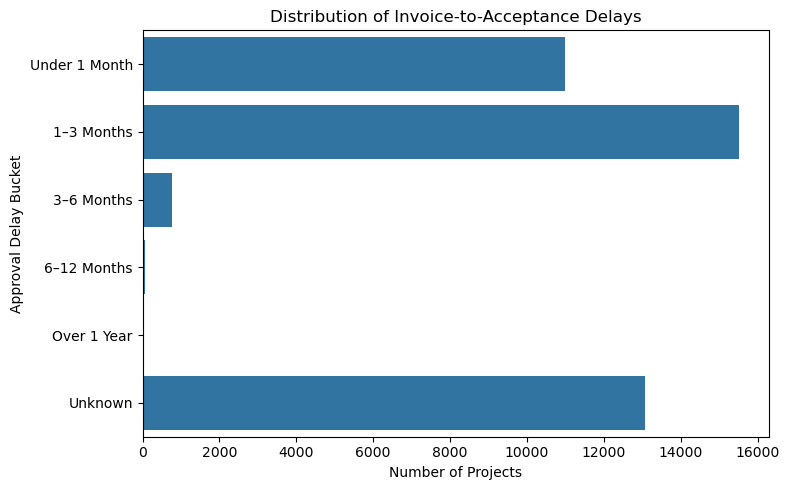

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=detailed, y='approval_delay_bucket', order=[
    'Under 1 Month', '1–3 Months', '3–6 Months', '6–12 Months', 'Over 1 Year', 'Unknown'
])
plt.title("Distribution of Invoice-to-Acceptance Delays")
plt.xlabel("Number of Projects")
plt.ylabel("Approval Delay Bucket")
plt.tight_layout()
plt.show()

### Normalized Financial Metrics

This section derives cost-based features that account for project size, time, and inflation-adjusted baselines. These allow for more apples-to-apples comparisons across projects and reduce skew when training ML models.

**Features Created:**
- `adjusted_expended_per_sqft`: Cost efficiency based on square footage
- `adjusted_expended_per_month`: Monthly spend rate normalized by duration
- `log_adjusted_expended`: Log-transformed cost to reduce long-tail effects
- `budget_vs_actual`: Dollar difference between expected (`TPC`) and actual cost
- `cost_overrun_ratio`: Ratio of actual to expected cost, capped to avoid outliers

These are helpful for:
- Detecting cost efficiency or excess
- Smoothing input features for tree-based models
- Understanding budget reliability


In [17]:
# Avoid divide-by-zero or NaNs
detailed['adjusted_expended'] = pd.to_numeric(detailed['adjusted_expended'], errors='coerce')
detailed['SQFT'] = pd.to_numeric(detailed['SQFT'], errors='coerce')
detailed['project_duration_months'] = pd.to_numeric(detailed['project_duration_months'], errors='coerce')
detailed['TPC'] = pd.to_numeric(detailed['TPC'], errors='coerce')

# Normalized metrics
detailed['adjusted_expended_per_sqft'] = detailed['adjusted_expended'] / detailed['SQFT']
detailed['adjusted_expended_per_month'] = detailed['adjusted_expended'] / detailed['project_duration_months']

# Log transformation
detailed['log_adjusted_expended'] = np.log1p(detailed['adjusted_expended'])

# Budget vs actual
detailed['budget_vs_actual'] = detailed['TPC'] - detailed['adjusted_expended']

# Overrun ratio (capped to avoid division by zero or extreme inflation)
detailed['cost_overrun_ratio'] = (
    detailed['adjusted_expended'] / detailed['TPC'].replace(0, np.nan)
).clip(upper=5)


/opt/miniconda3/envs/ml-env/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
# Preview financial features
detailed[['PID', 'adjusted_expended', 'SQFT', 'adjusted_expended_per_sqft',
          'project_duration_months', 'adjusted_expended_per_month',
          'log_adjusted_expended', 'TPC', 'budget_vs_actual', 'cost_overrun_ratio']].drop_duplicates().sample(10, random_state=7)

,PID,adjusted_expended,SQFT,adjusted_expended_per_sqft,project_duration_months,adjusted_expended_per_month,log_adjusted_expended,TPC,budget_vs_actual,cost_overrun_ratio
34750,UMA0801,4906.078319,94000.0,0.052192,79.2,61.945433,8.498434,7.295814e+07,7.295323e+07,0.000067
8979,DMH0501,4143.231219,428000.0,0.009680,98.6,42.020601,8.329473,2.965114e+08,2.965072e+08,0.000014
34009,TRC9910,5717.466300,254229.0,0.022489,80.1,71.379105,8.651456,9.980177e+07,9.979606e+07,0.000057
27219,SDW1501,69505.146721,0.0,inf,87.4,795.253395,11.149170,3.589647e+07,3.582696e+07,0.001936
32366,TRC1209,1445.763317,NaN,NaN,62.2,23.243783,7.277084,5.662092e+07,5.661947e+07,0.000026
6992,DDS1405,17025.090632,NaN,NaN,35.1,485.045317,9.742502,1.746774e+06,1.729749e+06,0.009747
3926,BSC1301,143.455457,15962.0,0.008987,18.5,7.754349,4.972971,6.467159e+06,6.467016e+06,0.000022
19439,MBC1601,274.980311,NaN,NaN,14.8,18.579751,5.620330,2.179979e+06,2.179704e+06,0.000126
33461,TRC2001,2337.581918,0.0,inf,44.0,53.126862,7.757300,6.869088e+06,6.866750e+06,0.000340
36375,UMB0502,3585.320346,NaN,NaN,104.2,34.408065,8.184882,2.688802e+07,2.688443e+07,0.000133


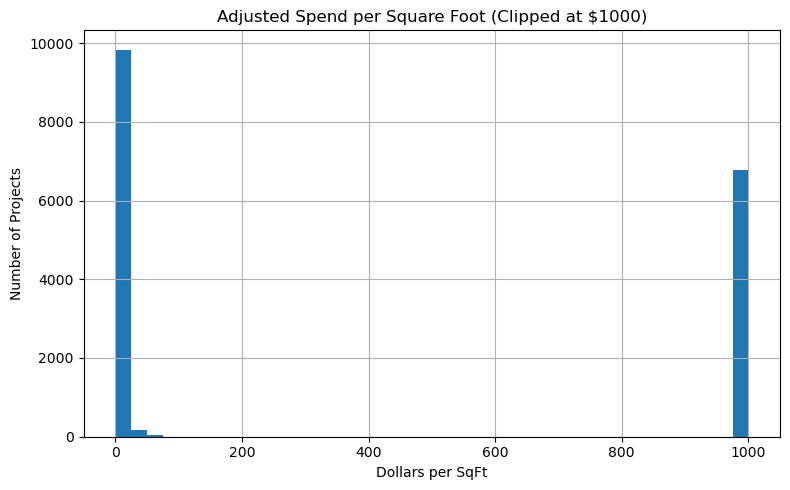

In [19]:
plt.figure(figsize=(8,5))
detailed['adjusted_expended_per_sqft'].dropna().clip(0, 1000).hist(bins=40)
plt.title("Adjusted Spend per Square Foot (Clipped at $1000)")
plt.xlabel("Dollars per SqFt")
plt.ylabel("Number of Projects")
plt.grid(True)
plt.tight_layout()
plt.show()

## Exploratory Data Analysis (EDA)

This section deepens our understanding of the project and spending behavior using multiple analytical lenses:

1. **Yearly Completions:** Trend of accepted projects over time — captures macroeconomic and policy impacts.
2. **Regional Spend Distribution:** Identifies which counties consume the most state funds.
3. **Seasonality Patterns:** Tracks quarterly funding behaviors to inform budget timing.
4. **Pacing vs Cost Impact:** Analyzes how spending trajectory (front- vs. back-loaded) correlates with cost efficiency.

These visual and statistical summaries go beyond basic description to frame hypotheses, refine model inputs, and detect structural inefficiencies.

### Project Completions Over Time

This chart illustrates the number of unique projects completed each year, based on the acceptance year recorded in the dataset. 

From the visual, we observe a consistent upward trend in project completions between 2004 and 2015, peaking around 2014–2015. This likely reflects a period of increased capital investment or strategic expansion within the state’s infrastructure program.

However, post-2015, there is a noticeable decline in project completions year-over-year. This could reflect budget tightening, shifting policy priorities, or potential delays in project timelines. The sharp drop after 2021 may also be partly due to data lags or incomplete records for more recent years.

Understanding these temporal patterns is important for forecasting future spending needs and identifying external factors (such as funding cycles or economic downturns) that influence project delivery rates.


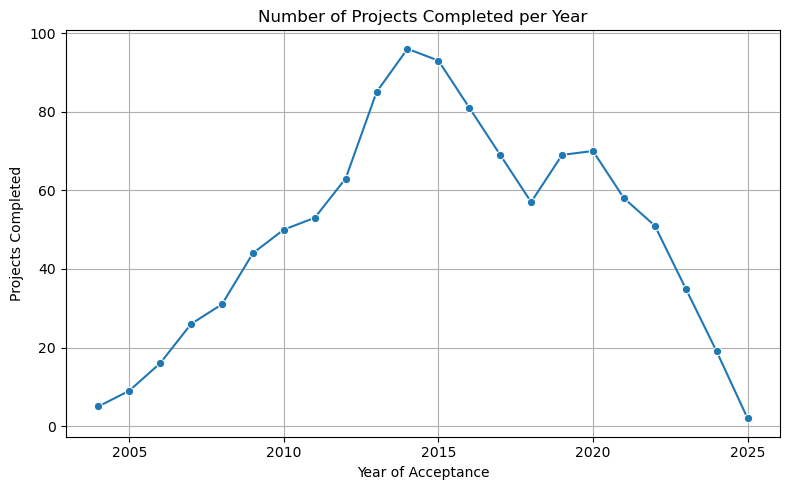

In [20]:
project_completions = detailed.groupby(detailed['acceptance_date'].dt.year)['PID'].nunique().reset_index()
project_completions.columns = ['Year', 'Num_Projects']

plt.figure(figsize=(8, 5))
sns.lineplot(data=project_completions, x='Year', y='Num_Projects', marker='o')
plt.title("Number of Projects Completed per Year")
plt.xlabel("Year of Acceptance")
plt.ylabel("Projects Completed")
plt.grid(True)
plt.tight_layout()
plt.show()

### Top 15 Counties by Adjusted Total Spending

This horizontal bar chart displays the top 15 counties in Massachusetts ranked by total inflation-adjusted capital spending. The adjustments are based on RSMeans escalation factors to bring all values to 2025 dollars, enabling fair comparisons across time.

Key insights include:

- **Worcester County** clearly leads in overall capital investment, followed by **Suffolk**, **Essex**, and **Middlesex** counties.
- The presence of duplicate or inconsistently capitalized county names (e.g., "Worcester" vs. "WORCESTER") suggests the need for additional data cleaning to consolidate categories and ensure accurate aggregation.
- Urban and densely populated counties dominate the top of the chart, which aligns with expectations given infrastructure demands and larger project footprints.
- The wide disparity between counties also raises questions about geographic equity in capital allocations, warranting further investigation into spending per square foot or per capita.

This kind of regional breakdown can help inform more balanced infrastructure planning and flag potential over- or under-investment zones.

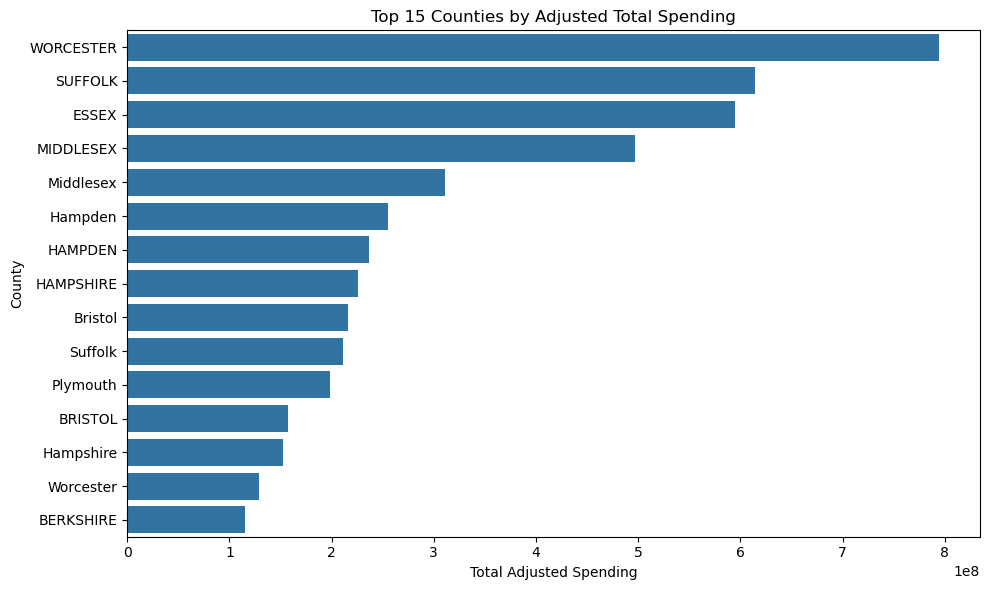

In [21]:
regional_spending = (
    detailed.groupby('County')['adjusted_expended']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(data=regional_spending.head(15), x='adjusted_expended', y='County')
plt.title("Top 15 Counties by Adjusted Total Spending")
plt.xlabel("Total Adjusted Spending")
plt.ylabel("County")
plt.tight_layout()
plt.show()


### Seasonality in Spending (Quarterly View)

This line chart illustrates total inflation-adjusted project spending across quarters, from 2004 through 2025. To improve readability, x-axis ticks are shown for every fourth quarter.

Key observations:

- **Spending ramps up sharply around 2010**, reaching a peak in Q2–Q3 of 2011. This period likely reflects stimulus or strategic infrastructure investment.
- After 2015, there is a **steady decline in quarterly spending**, with a few modest rebounds, potentially reflecting funding constraints, project delays, or changes in strategic priorities.
- The pattern displays **mild seasonality**, where some years show consistent Q2 or Q3 peaks, possibly aligning with construction cycles or fiscal planning calendars.
- **Post-2020** spending drops off more rapidly—this could be influenced by pandemic-related disruptions or reporting lags in recent years.

This visualization allows us to identify high-activity windows and raises questions about funding predictability, procurement pacing, or policy shifts over time. It could also support predictive modeling by capturing quarterly fluctuations.

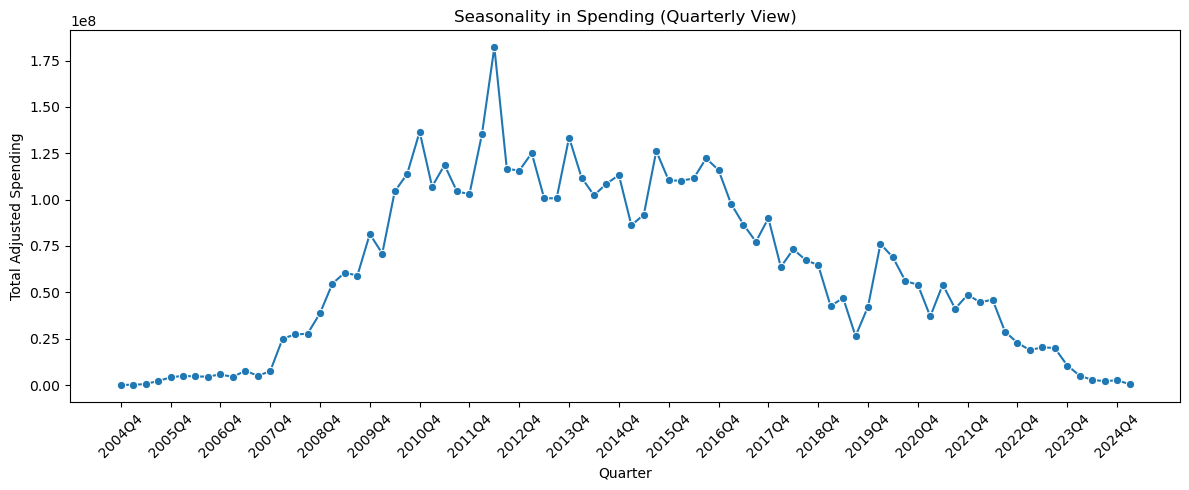

In [22]:
# Create quarter string column from Period
detailed['acceptance_quarter'] = detailed['acceptance_date'].dt.to_period('Q').astype(str)

# Now group and plot
quarterly_trend = (
    detailed.groupby('acceptance_quarter')['adjusted_expended']
    .sum()
    .reset_index()
)

xticks = quarterly_trend['acceptance_quarter'][::4]  # every 4th quarter
plt.figure(figsize=(12, 5))
sns.lineplot(data=quarterly_trend, x='acceptance_quarter', y='adjusted_expended', marker='o')
plt.title("Seasonality in Spending (Quarterly View)")
plt.xlabel("Quarter")
plt.ylabel("Total Adjusted Spending")
plt.xticks(ticks=xticks, rotation=45)
plt.tight_layout()
plt.show()

### Cost Overruns by Spend Pacing

This boxplot compares the distribution of cost overrun ratios between two spending profiles: **Front-Loaded** vs. **Back-Loaded** projects. Projects were categorized based on whether a majority of their spend occurred early (Front-Loaded) or later (Back-Loaded) in their timeline.

**Key insights:**

- **Front-Loaded projects exhibit significantly higher cost overrun ratios.** Their median overrun is visibly higher, with several extreme outliers indicating projects where actual spend greatly exceeded budget.
- **Back-Loaded projects show minimal overruns overall,** with a narrow interquartile range and most data points tightly clustered around zero.
- This finding may suggest that projects that accelerate early spending are more prone to cost mismanagement, scope creep, or unforeseen challenges.
- Alternatively, front-loaded spending might be symptomatic of high-risk, fast-track projects or ones experiencing early-stage estimation errors.

These pacing-based insights could inform future risk forecasting, early warning systems, and project controls for budget adherence.

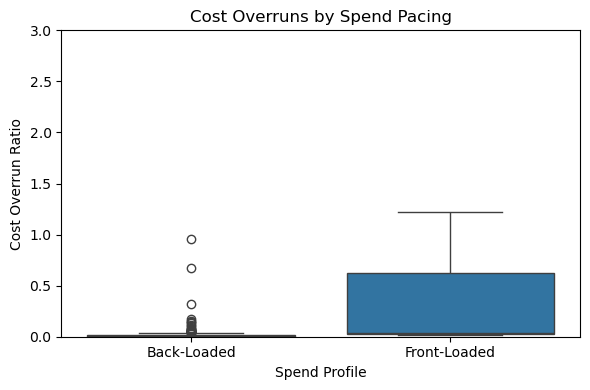

In [23]:
pace_groups = detailed.drop_duplicates('PID').copy()
pace_groups['spend_pacing'] = np.where(
    pace_groups['is_front_loaded_spend'], 'Front-Loaded', 'Back-Loaded'
)

plt.figure(figsize=(6, 4))
sns.boxplot(data=pace_groups, x='spend_pacing', y='cost_overrun_ratio')
plt.title("Cost Overruns by Spend Pacing")
plt.xlabel("Spend Profile")
plt.ylabel("Cost Overrun Ratio")
plt.ylim(0, 3)
plt.tight_layout()
plt.show()

## Modeling Enhancements

We rebuild our predictive models using the inflation-adjusted cost (`adjusted_expended`) as the new target. This eliminates inflation bias and enables apples-to-apples comparisons across projects over time. We also filter for pre-construction features to avoid post-completion leakage, and explore multiple model types (Random Forest, XGBoost, LightGBM) with cross-validation for robustness.


In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Select only pre-construction features
# Updated pre-construction columns after inspecting nulls
pre_construction_cols = [
    'Project_FY', 'PayClass FY', 'is_front_loaded_spend',
    'City', 'County', 'Construction Type', 'Agy', 'SQFT'
    # Removed: 'Capital Investment Category'
]

# Drop rows with nulls only in the features that still matter
model_data = detailed[pre_construction_cols + ['adjusted_expended']].dropna()

# Confirm how many rows remain
print(model_data.shape)

# One-hot encode categorical variables
model_data = pd.get_dummies(model_data, columns=[
    'City', 'County', 'Construction Type', 'Agy'
], drop_first=True)

# Train–test split
X = model_data.drop('adjusted_expended', axis=1)
y = model_data['adjusted_expended']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(9877, 9)


### Model Comparison

We trained three tree-based regression models (Random Forest, XGBoost, and LightGBM) using the cleaned and one-hot encoded pre-construction data. Evaluation metrics include:

- **R² Score (explained variance)**
- **MAE (mean absolute error)**
- **RMSE (root mean squared error)**

This allows us to directly compare baseline predictive performance across architectures.


In [25]:
# Initialize models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
lgbm = LGBMRegressor(n_estimators=100, random_state=42)

models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "LightGBM": lgbm
}

# Dictionary to collect metrics
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    results[name] = {
        "R2": round(r2, 3),
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2)
    }

# Display comparison
results_df = pd.DataFrame(results).T
display(results_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 7901, number of used features: 52
[LightGBM] [Info] Start training from score 193537.750100


,R2,MAE,RMSE
Random Forest,0.577,155509.52,441754.74
XGBoost,0.574,157515.31,443427.39
LightGBM,0.558,170745.29,451618.20


We first evaluated three regression models using a traditional 80/20 train-test split to measure their ability to predict inflation-adjusted spending (adjusted_expended). Performance was assessed using R² (coefficient of determination), MAE (mean absolute error), and RMSE (root mean squared error). 

Random Forest slightly outperformed both XGBoost and LightGBM across all metrics. It achieved the best R² and lowest MAE and RMSE, suggesting it most effectively captured relationships in the test set.

In [26]:
from sklearn.model_selection import cross_val_score, KFold

# Use 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(random_state=42)
}

cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
    cv_results.append({
        'Model': name,
        'R2 Mean': scores.mean(),
        'R2 Std': scores.std()
    })

cv_df = pd.DataFrame(cv_results)
display(cv_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 7901, number of used features: 52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 185882.548954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 7902, number of used features: 52
[LightGBM] [Info] Start training from score 181628.771495
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[Light

,Model,R2 Mean,R2 Std
0,Random Forest,0.575445,0.071645
1,XGBoost,0.575702,0.071822
2,LightGBM,0.559577,0.056396


To evaluate generalizability and model consistency, we ran 5-fold cross-validation using R² as the performance metric. The results reflect the average and standard deviation across five validation folds.

XGBoost and Random Forest performed similarly in mean R², but LightGBM showed the lowest variance (R² Std = 0.0564), indicating slightly more consistent performance across folds. Although LightGBM underperformed slightly on average, its reduced variability suggests potential value for stable deployment.

### Residual Plots: Random Forest, XGBoost, LightGBM

The residual plots visualize the difference between actual and predicted values (residuals) for each model.

- Ideally, residuals should be symmetrically scattered around zero with no clear pattern. This indicates that the model is unbiased and captures the true data structure well.
- **Random Forest** shows a fairly balanced residual spread, though there may be signs of underprediction at higher actual values.
- **XGBoost** exhibits similar behavior but with slightly wider dispersion.
- **LightGBM** shows a consistent residual pattern but with more spread, indicating possible underfitting or limitations in feature interaction modeling.

These insights help verify the assumptions of linearity, homoscedasticity, and independence required for stable predictive modeling.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 7901, number of used features: 52
[LightGBM] [Info] Start training from score 193537.750100


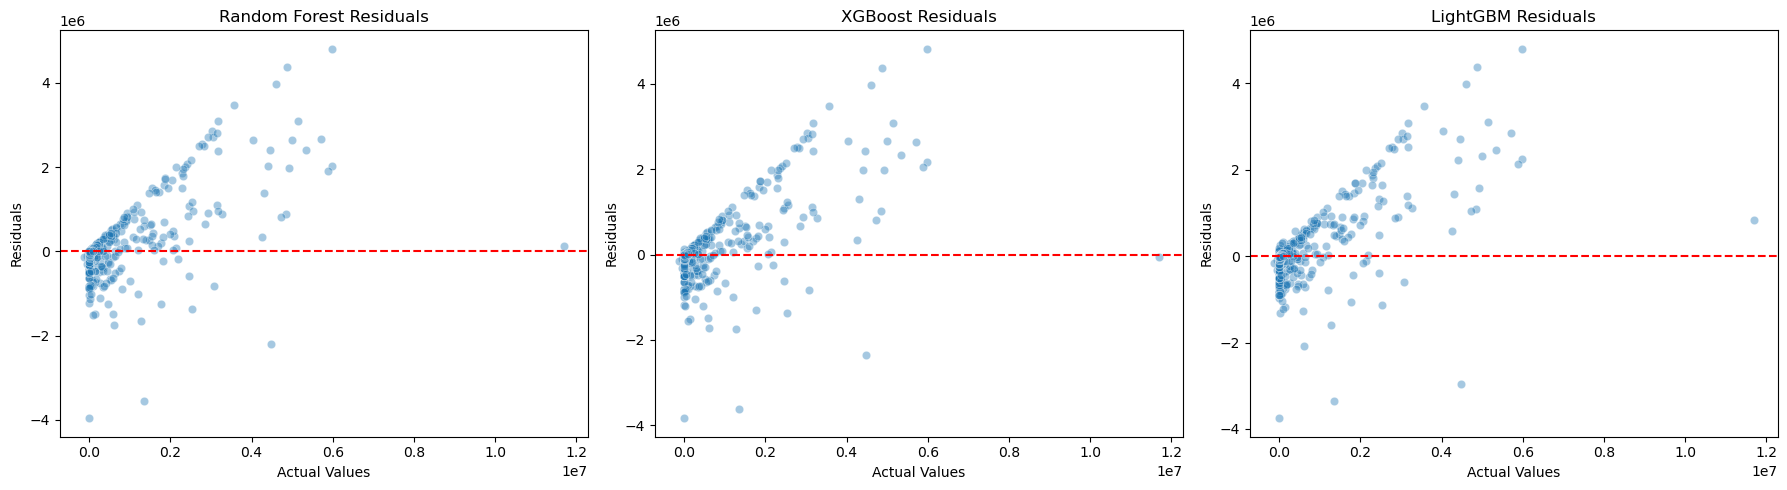

In [27]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Instantiate and train models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
lgb_model = LGBMRegressor(random_state=42)

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

# Predict on test data
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
lgb_preds = lgb_model.predict(X_test)

# Calculate residuals
rf_residuals = y_test - rf_preds
xgb_residuals = y_test - xgb_preds
lgb_residuals = y_test - lgb_preds

# Plot residuals
plt.figure(figsize=(18, 5))

# Random Forest
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=rf_residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Random Forest Residuals")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")

# XGBoost
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=xgb_residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("XGBoost Residuals")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")

# LightGBM
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=lgb_residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("LightGBM Residuals")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()


The residual plots above visualize the prediction errors (residuals) of the three models on the test set, defined as the difference between actual and predicted values. Ideally, residuals should be randomly scattered around zero without any clear pattern. Here's what we observe:

- **Random Forest Residuals:**  
  Residuals are fairly concentrated around zero but tend to widen as actual costs increase. This suggests the model underfits larger projects and struggles with extreme values, despite capturing the general structure well.

- **XGBoost Residuals:**  
  Similar behavior to Random Forest, with slightly more dispersion and some extreme underpredictions. XGBoost performs comparably in aggregate metrics but may be less stable for outliers in this dataset.

- **LightGBM Residuals:**  
  LightGBM shows a broader spread in residuals, indicating higher variance in its predictions. The model seems to slightly overpredict low-cost projects and underpredict high-cost ones, consistent with its lower R² and higher MAE/RMSE.

While all three models struggle somewhat with large outliers, Random Forest appears to deliver the most balanced and stable predictions, consistent with its superior MAE and RMSE performance. XGBoost closely follows, while LightGBM may require further tuning to close the gap.

In [28]:
# Create SHAP explainer for LightGBM
explainer = shap.Explainer(lgb_model)

# Compute SHAP values
shap_values = explainer(X_test)

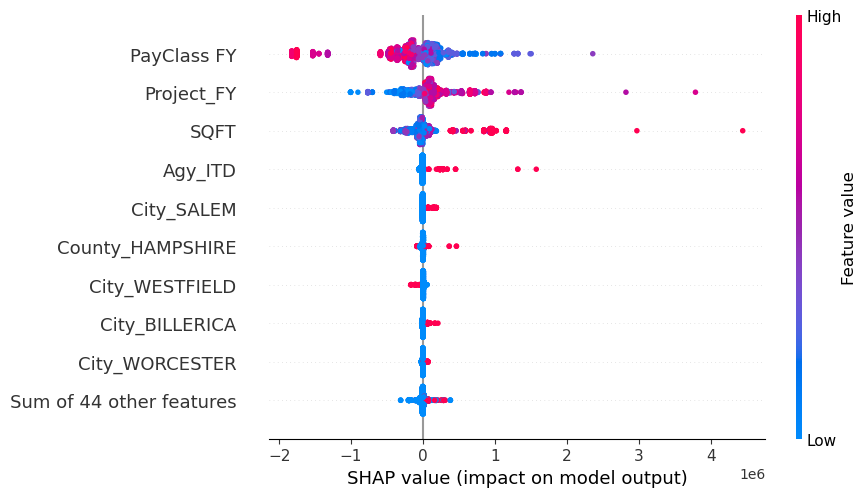

In [29]:
# Summary plot for feature impact
shap.plots.beeswarm(shap_values)

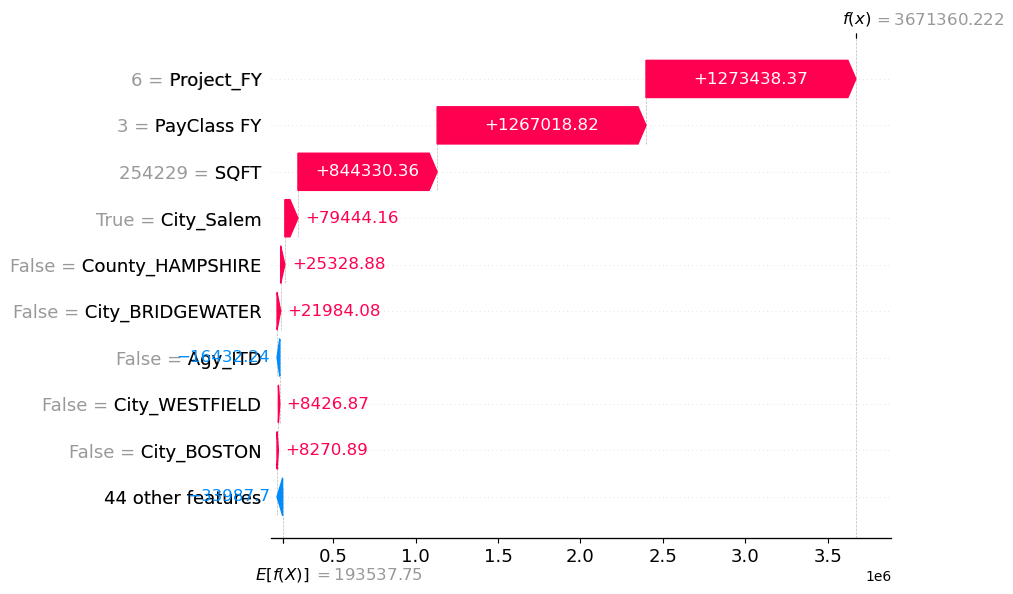

In [30]:
# Force plot for one observation
shap.plots.waterfall(shap_values[0])

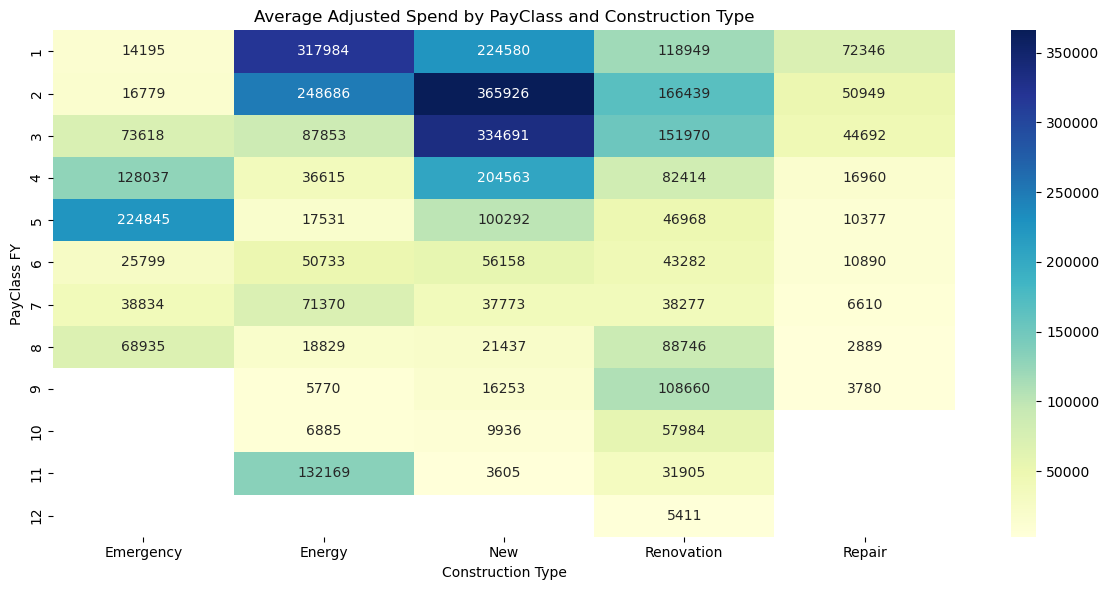

In [31]:
# Pivot for heatmap
heatmap_data = detailed.pivot_table(
    index='PayClass FY',
    columns='Construction Type',
    values='adjusted_expended',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Average Adjusted Spend by PayClass and Construction Type")
plt.xlabel("Construction Type")
plt.ylabel("PayClass FY")
plt.tight_layout()
plt.show()


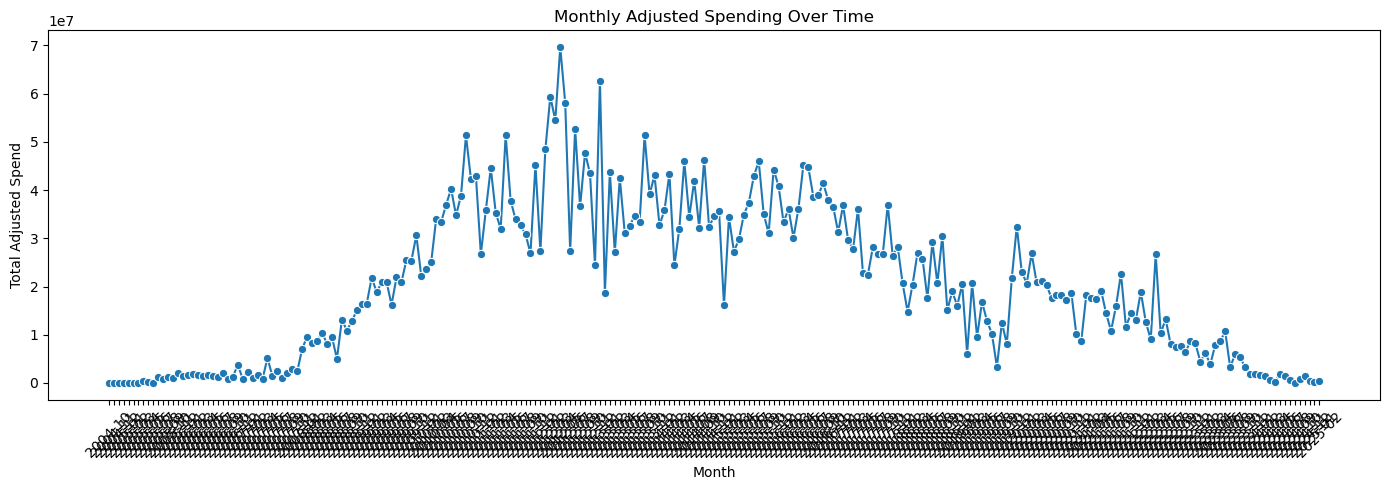

In [32]:
# Create year-month period for grouping
detailed['year_month'] = detailed['acceptance_date'].dt.to_period('M')

# Group and plot
monthly_spending = (
    detailed.groupby('year_month')['adjusted_expended']
    .sum()
    .reset_index()
)
monthly_spending['year_month'] = monthly_spending['year_month'].astype(str)

plt.figure(figsize=(14, 5))
sns.lineplot(data=monthly_spending, x='year_month', y='adjusted_expended', marker='o')
plt.title("Monthly Adjusted Spending Over Time")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Adjusted Spend")
plt.tight_layout()
plt.show()


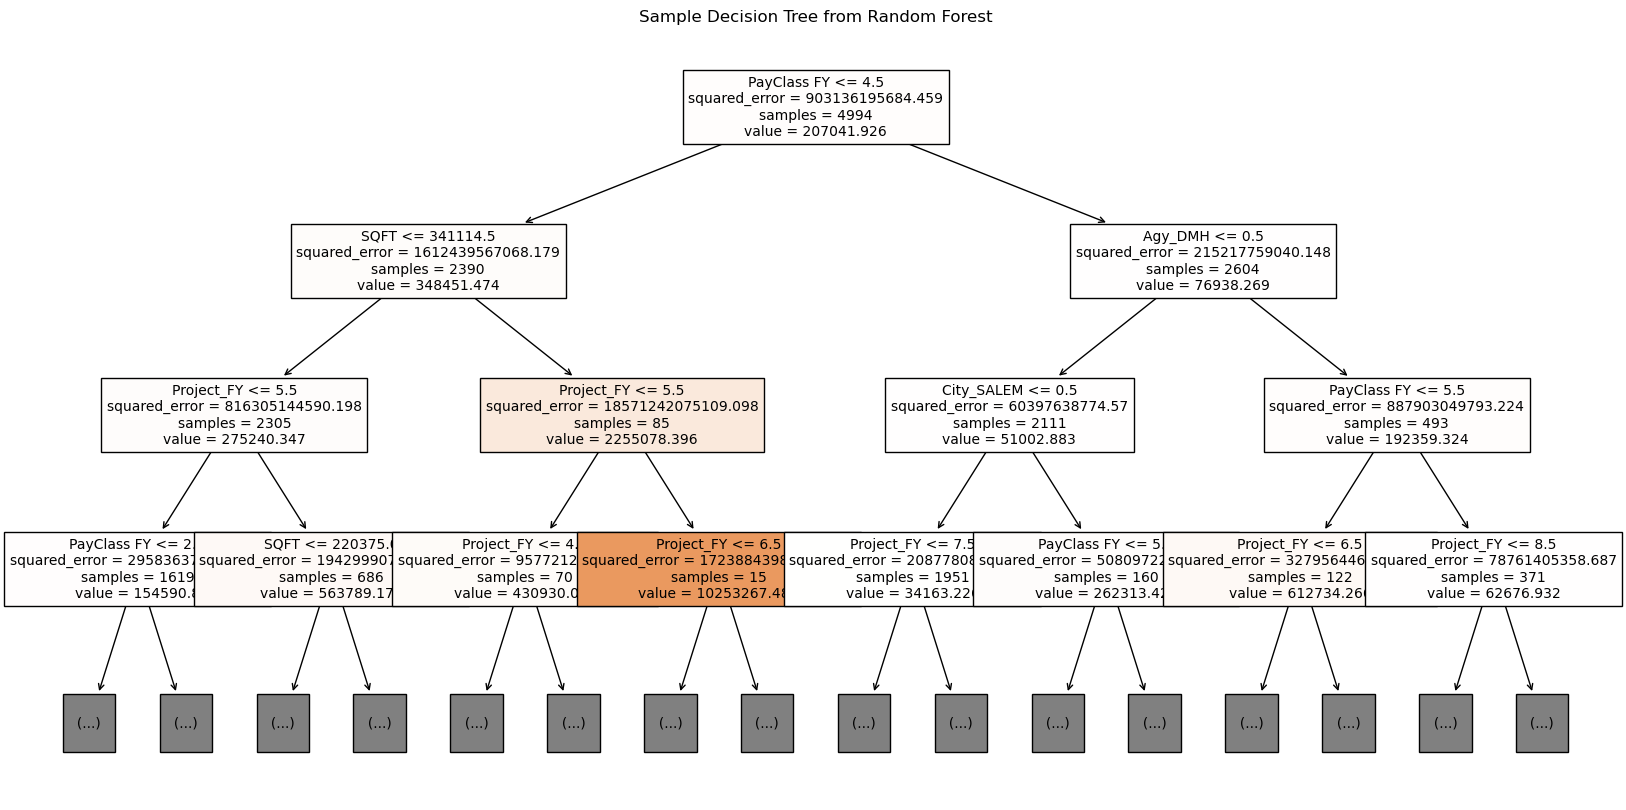

In [33]:
from sklearn.tree import plot_tree

# Extract a single tree from the fitted random forest
tree_model = rf_model.estimators_[0]

# Plot the tree (you may limit max_depth for legibility)
plt.figure(figsize=(20, 10))
plot_tree(tree_model, 
          feature_names=X.columns, 
          filled=True, 
          max_depth=3, 
          fontsize=10)
plt.title("Sample Decision Tree from Random Forest")
plt.show()
